# Analyze Cibersort Fractions Matrix as if it was the output of a multi classfication model
```
Andrew Davidson
aedavids@ucsc.edu
```

each GTEx or TCGA sample was assumed to be a single type. e.g. Lung or LUAD

ref: notebook jan 14 2022
- createCibersortMixtureMatrix.ipynb
    - creates expected fractions matrix
- 12/10 page 100
- 12/13 page 103
- [one-hot-encoding-in-python-with-pandas-and-scikit-learn](https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/)
- [getting_column_label_of_max_value_in_each_row_in_pandas](https://www.skytowner.com/explore/getting_column_label_of_max_value_in_each_row_in_pandas_datafrme#:~:text=To%20get%20the%20column%20label,(axis%3D1)%20method.)
- [seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
- fractionsAsMulticlassClassificationPOC.ipynb
    - This notebook has a lot of debug coce

In [1]:
import bme263DataVis.utilities as utl
from IPython.display import display
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
import numpy as np
import pathlib as pl
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

imgOutDir = pl.Path("img/fractionsAsMulticlassClassificationPOC")
imgOutDir.mkdir(parents=True, exist_ok=True)

# useful function for converting plot titles to strings
# https://stackoverflow.com/a/1007615/4586180
import re
def urlify(s):

    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)

    # Replace all runs of whitespace with a single dash
    s = re.sub(r"\s+", '-', s)

    return s

# Prints: I-cant-get-no-satisfaction"
#print(urlify("I can't get no satisfaction!"))

## Load exected fractions

In [2]:
rootDir = pl.Path('/private/groups/kimlab/GTEx_TCGA/')

gspDir = 'geneSignatureProfiles/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/ciberSort'
expectedFractionsFileName = 'GTEx_TCGA_TrainGroupby_expectedFractions.txt'
expectedFractionsPath = rootDir.joinpath(gspDir).joinpath(expectedFractionsFileName)
print(expectedFractionsPath)

/private/groups/kimlab/GTEx_TCGA/geneSignatureProfiles/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/ciberSort/GTEx_TCGA_TrainGroupby_expectedFractions.txt


## Load predicted fractions

In [3]:
ciberSortResultsFile = 'CIBERSORTx_GTEx_TCGA_TrainGroupby_mixture_Results.txt'
ciberSortResultsFile = rootDir.joinpath('cibersort.out/GTEx_TCGA_TrainGroupby_mixture').joinpath(ciberSortResultsFile)
print(ciberSortResultsFile)

/private/groups/kimlab/GTEx_TCGA/cibersort.out/GTEx_TCGA_TrainGroupby_mixture/CIBERSORTx_GTEx_TCGA_TrainGroupby_mixture_Results.txt


In [4]:
#
# load data
#
expectedFractionsDF = pd.read_csv(expectedFractionsPath, sep='\t', index_col='sample_id')
print( f"expectedFractionsDF.shape: {expectedFractionsDF.shape}" )

cibersortFractionsDF = pd.read_csv(ciberSortResultsFile, sep='\t', index_col='Mixture')
print( f"cibersortFractionsDF.shape: {cibersortFractionsDF.shape}" )

#
# remove stat cols
#
statsCols = ['P-value', 'Correlation', 'RMSE' ]
predictionsDF = cibersortFractionsDF.loc[:, ~cibersortFractionsDF.columns.isin( statsCols)]
print( f"predictionsDF.shape: {predictionsDF.shape}" )

#
# treat predicition as if it was the output layer of a multiclassifier
# use hard max to call the class
#
byRow = 1

# weird we get a warning if we do not use a copy
xxxDF = predictionsDF.copy()
xxxDF['max'] = predictionsDF.copy().max(axis=byRow)
predictionsDF = xxxDF

#
# find the name of the class associated with the max value
# if 2 cols have same value, idxmax will return the first one. i.e. the sample category for the max fractional value
#
predictionsDF['predictedCat'] = predictionsDF.idxmax(axis=byRow)

confusionDF = predictionsDF.merge(right=expectedFractionsDF, how='inner', left_index=True, right_index=True)
# we have a lot of columns because both prediction and expected fractions have a col for each type
print( f"confusionDF.shape: {confusionDF.shape}" )

#confusionDF.loc[:, ['predictedCat', 'category']].head()

expectedFractionsDF.shape: (15801, 88)
cibersortFractionsDF.shape: (15801, 86)
predictionsDF.shape: (15801, 83)
confusionDF.shape: (15801, 173)


In [5]:
cfMatrix = confusion_matrix(confusionDF['category'], confusionDF['predictedCat'])
# print(type(cfMatrix))
print(cfMatrix.shape)
display(cfMatrix)

(83, 83)


array([[ 29,   1,   0, ...,   0,   0,   0],
       [  0, 396,   0, ...,   0,   0,   0],
       [  0, 321,   0, ...,   0,   0,   0],
       ...,
       [  0,  76,   0, ...,   9,   0,   0],
       [  0,  22,   0, ...,   1,  62,   0],
       [  0,   0,   0, ...,   0,   0, 433]])

In [6]:
def sanityTest(cfDF, cfMatrix):
    '''
    make sure the confusion matrix plot labels are correct by check true positives
    
    check for classes we did not make any predictions for and classess
    with out any true positives
    
    adjust for these error and compare true positive values to confirm plot labels
    are in correct order
    '''
    print(f'cfDF.shape: {cfDF.shape}')
    testDF = confusionDF.loc[:, ['category', 'predictedCat'] ]
    uniqueCategories = testDF['category'].unique()
    print(f'len(uniqueCategories): {len(uniqueCategories)}')
    
    uniquePredictedCat = testDF['predictedCat'].unique()
    print(f'len(uniquePredictedCat): {len(uniquePredictedCat)}')
    
    # there are 2 class that we did not make any predictions for!
    missingClassesSet = set(uniqueCategories) - set(uniquePredictedCat)
    print(f'\nclasses we did not make any predictions for: {missingClassesSet}')
    for category in missingClassesSet:
        selectRows = cfDF['category'] == category
        print(f'{category} has {cfDF.loc[selectRows,:].shape[0]} samples')
    
    # add fake TP predictions
    fakeDF = pd.DataFrame( {
                            "category" : ['Artery_Tibial', 'Bladder'],
                            "predictedCat" : ['Artery_Tibial', 'Bladder']
                            } 
                            , index = ['fakeSample1', 'fakeSample2']
                    )

    testDF = pd.concat( [testDF, fakeDF] )    

    # find true positivies
    selectRows = testDF['category'] == testDF['predictedCat']
    print(f'\nfind true positivies')
    
    truePosDF = testDF.loc[selectRows, ['category', 'predictedCat'] ]
    print(f'truePosDF.shape: {truePosDF.shape}')    
    
    truePosCountsDF = truePosDF.sort_values(by='category').groupby(by='category').count()
    
    # find class that do not have any true possitives
    truePosClassesSet = set( truePosCountsDF.index.to_list() )
    noTPSet = set(uniqueCategories) - truePosClassesSet
    print( f'\nclasses that do not have any true positives: {noTPSet}' )
    for category in noTPSet:
        selectRows = cfDF['category'] == category
        print(f'{category} has {cfDF.loc[selectRows,:].shape[0]} samples')
    
    # add fake true positive
    fakeDF = pd.DataFrame( {
                            #"category" : [np.NaN],
                            "predictedCat" : [0]
                            } 
                            , index = ['Adipose_Visceral_Omentum']
                    )
    truePosCountsDF = pd.concat( [truePosCountsDF, fakeDF] ).sort_index()# sort_values(by='predictedCat')
    
    cfMatrixTruePositiveNP = cfMatrix.diagonal()
    print(f'\ncfMatrixTruePositiveNP with fake samples:\n{cfMatrixTruePositiveNP}')
    
    print(f'\n truePosCountsDF with fake sample\n{truePosCountsDF.values.flatten()}')
    
    expectedDiff = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    diff = truePosCountsDF.values.flatten() - cfMatrixTruePositiveNP
    np.testing.assert_array_equal(expectedDiff, diff)
    
    
def testSanityTest():
    sanityTest(confusionDF, cfMatrix)
    
testSanityTest()

cfDF.shape: (15801, 173)
len(uniqueCategories): 83
len(uniquePredictedCat): 81

classes we did not make any predictions for: {'Artery_Tibial', 'Bladder'}
Artery_Tibial has 397 samples
Bladder has 9 samples

find true positivies
truePosDF.shape: (9590, 2)

classes that do not have any true positives: {'Adipose_Visceral_Omentum'}
Adipose_Visceral_Omentum has 325 samples

cfMatrixTruePositiveNP with fake samples:
[ 29 396   0 141   6   2   0 158 285   0  57  41  33 129  19  71 102  56
  51 125  11  95  21 138  65  21  65 127 103   2  14 150  29   8   5 174
  25  79 175 241 245  39 265 135  49 241 140 104 115  97 216  26  50 482
 359 171  95  28 101 224 196 161 125  39 108  24  42 203 322  65 139 160
  72 195  62 210 387  86   9  48   9  62 433]

 truePosCountsDF with fake sample
[ 29 396   0 141   6   2   1 158 285   1  57  41  33 129  19  71 102  56
  51 125  11  95  21 138  65  21  65 127 103   2  14 150  29   8   5 174
  25  79 175 241 245  39 265 135  49 241 140 104 115  97 216  26  5

In [7]:
def calculateRowPercentages(cm):
    '''
    divides each value in a row by the row totoal
    
    arguments:
        cm: a confusion matrix
        
    returns
        a numpy array with same shape as cm 
    '''
    byRows = 1
    rowMarginEquals1 = np.sum(cm, axis=byRows)
    #print(f"rowMarginEquals1\n{rowMarginEquals1}")
    #print(f"rowMarginEquals1.shape\n{rowMarginEquals1.shape}")

    rowMarginEquals1Reshape = rowMarginEquals1.reshape(rowMarginEquals1.shape[0], 1)
    #print(f"\n rowMarginEquals1Reshape\n{rowMarginEquals1Reshape}")

    ret = cm/rowMarginEquals1Reshape
    
    return ret
    
    
def testCalculateRowPercentages(cm):
    ret = calculateRowPercentages(cm)
    print(ret)
    
testCalculateRowPercentages( cfMatrix )

[[0.60416667 0.02083333 0.         ... 0.         0.         0.        ]
 [0.         0.99497487 0.         ... 0.         0.         0.        ]
 [0.         0.98769231 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.89411765 0.         ... 0.10588235 0.         0.        ]
 [0.         0.23404255 0.         ... 0.0106383  0.65957447 0.        ]
 [0.         0.         0.         ... 0.         0.         0.95584989]]


In [8]:
def createHeatMapAnnotations( rowPercentages ):
    '''
    seaborn heatmap argument annot = True display the cfMatrix cell values.
    fmt='.2%' argument would display the number cell values with 2 decimal places
    
    our confustion matrix is large, and has a lot of zeros making it hard to visualy
    interpurt the data.
    
    retuns 
        a numpy array of string with the same dimensions as rowPercentages
        use this as the value for the argument annot, do not use fmt
    '''
    numRows = rowPercentages.shape[0]
    numCols = rowPercentages.shape[1]
    
    bufferList = [0] * numRows
    for i in range(numRows):        
        a = [""] * numCols 
        for j in range(numCols):
            d = rowPercentages[i,j]
            if d > 0.0:
                #s = '{:.2f}'.format(d)
                s = '{}%'.format( round(d * 100), digits=0) 
                a[j] = s
                
        aNP = np.array( a, dtype=str )#.reshape( (1,numCols) )
        bufferList[i] = aNP
        
    return np.array(bufferList, dtype=object) 
    
def testCreateHeatMapAnnotations():
    rowPercentages = calculateRowPercentages(cfMatrix)
    print(f'rowPercentages.shape: {rowPercentages.shape}')
    print(rowPercentages)
    ret = createHeatMapAnnotations( rowPercentages )
    print(f'ret.shape: {ret.shape}')
    print(ret)
    
testCreateHeatMapAnnotations()

rowPercentages.shape: (83, 83)
[[0.60416667 0.02083333 0.         ... 0.         0.         0.        ]
 [0.         0.99497487 0.         ... 0.         0.         0.        ]
 [0.         0.98769231 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.89411765 0.         ... 0.10588235 0.         0.        ]
 [0.         0.23404255 0.         ... 0.0106383  0.65957447 0.        ]
 [0.         0.         0.         ... 0.         0.         0.95584989]]
ret.shape: (83, 83)
[['60%' '2%' '' ... '' '' '']
 ['' '99%' '' ... '' '' '']
 ['' '99%' '' ... '' '' '']
 ...
 ['' '89%' '' ... '11%' '' '']
 ['' '23%' '' ... '1%' '66%' '']
 ['' '' '' ... '' '' '96%']]


In [9]:
def plotConfusionMatrix(confusionData, labels, annotations, imgOutDir, title, pageWidthInInches, 
                        pageHeightInInches, displayCounts=False):
    '''
    arguments
        confusionData, labels, 
        
        annotations
            string values to display in heat map cells, must have same shape as confusionData
        
        imgOutDir, title, pageWidthInInches, pageHeightInInches
        
        displayCounts:
            boolean: default = False
            if true fmt is set to '.0f', and annotations are not displayed
    '''
    
    plotUtils =  utl.MatPlotLibUtilities()
    fig = plt.figure( figsize=(pageWidthInInches, pageHeightInInches) )

    # correlation
    cbarPanelWidthInInches = 0.25 #0.5
    panelWidthInInches = pageWidthInInches - cbarPanelWidthInInches
    panelHeightInInches = pageHeightInInches 
    leftRelativeSize = 0
    bottomRelativeSize = 0
    panel = plotUtils.createPanel(fig, panelWidthInInches, panelHeightInInches, 
                                             leftRelativeSize, bottomRelativeSize)
    
    cbarPanelHeightInInches = panelHeightInInches - 2 #1
    cbarLeftRelativeSize = 0.99 #0.985 #0.975 # 0.95   # % of fig width
    cbarBottomRelativeSize = 0.08 #0.1 #0.125 #0.15 # 0.10 # % of fig height
    cbarPanel = plotUtils.createPanel(fig, cbarPanelWidthInInches, cbarPanelHeightInInches, 
                                             cbarLeftRelativeSize, cbarBottomRelativeSize)

    if (displayCounts):
        panel = sns.heatmap( confusionData 
                            , xticklabels = labels
                            , yticklabels = labels
                            , ax = panel
                            , cbar_ax = cbarPanel
                            , cmap = "Blues"
                            , annot = True # display the numeric values in confusionData
                            #, fmt='.2%' # use if annot = True # default is '.2g'
                            , fmt=".0f" # use to display true positive counts
                            , square=True
                            , linecolor = "black" # default is "white"
                            , linewidths = 1.0
                   )
    else:
        panel = sns.heatmap( confusionData 
                        , xticklabels = labels
                        , yticklabels = labels
                        , ax = panel
                        , cbar_ax = cbarPanel
                        , cmap = "Blues"
                        , annot = annotations
                        , fmt='' # required if our annotations are strings
                        , square=True
                        , linecolor = "black" # default is "white"
                        , linewidths = 1.0

               )        

    panel.set_title(title)
    panel.set_ylabel('Actual')
    panel.set_xlabel('Predicted')

    # https://drawingfromdata.com/seaborn/matplotlib/visualization/rotate-axis-labels-matplotlib-seaborn.html
    panel.set_xticklabels(panel.get_xticklabels(), rotation=45, horizontalalignment='right')

    imgFile = imgOutDir.joinpath( urlify(title) + ".png" )
    print(f"save: {imgFile}")
    plt.savefig( imgFile , bbox_inches='tight', dpi=600,  facecolor="white", transparent=True)

In [10]:
def plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start, end, displayCounts=False):
    pageWidthInInches  = 8
    pageHeightInInches = 8
    
    if displayCounts:
        confusionData = cfMatrix
        annot = None
    else :
        confusionData = calculateRowPercentages( cfMatrix )
        annotations = createHeatMapAnnotations( confusionData )
        annot = annotations[start:end, start:end]

    cfMatrixL = confusionData[start:end, start:end] # confusion_matrix is TP, FP counts we want percentages 
    labelsL = labels[start:end]
    plotConfusionMatrix(cfMatrixL, labelsL, annot, imgOutDir, title, pageWidthInInches, 
                        pageHeightInInches, displayCounts)

In [11]:
# we did not make any predictions for: {'Bladder', 'Artery_Tibial'}
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# labels: List of labels to index the matrix. This may be used to reorder or select a subset of labels.
# If None is given, those that appear at least once in y_true or y_pred are used in sorted order.
default = None
cfMatrix = confusion_matrix(confusionDF['category'], confusionDF['predictedCat'], labels=default)
# create labels from ground trueth else confusion matrix will labels will be off
labels = sorted( set( confusionDF['category'].to_list() ) )


# for each row display the TP and FP as a %
# ie. row margin should sum to one
confusionData = calculateRowPercentages( cfMatrix )
annotations = createHeatMapAnnotations( confusionData )

save: img/fractionsAsMulticlassClassificationPOC/Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


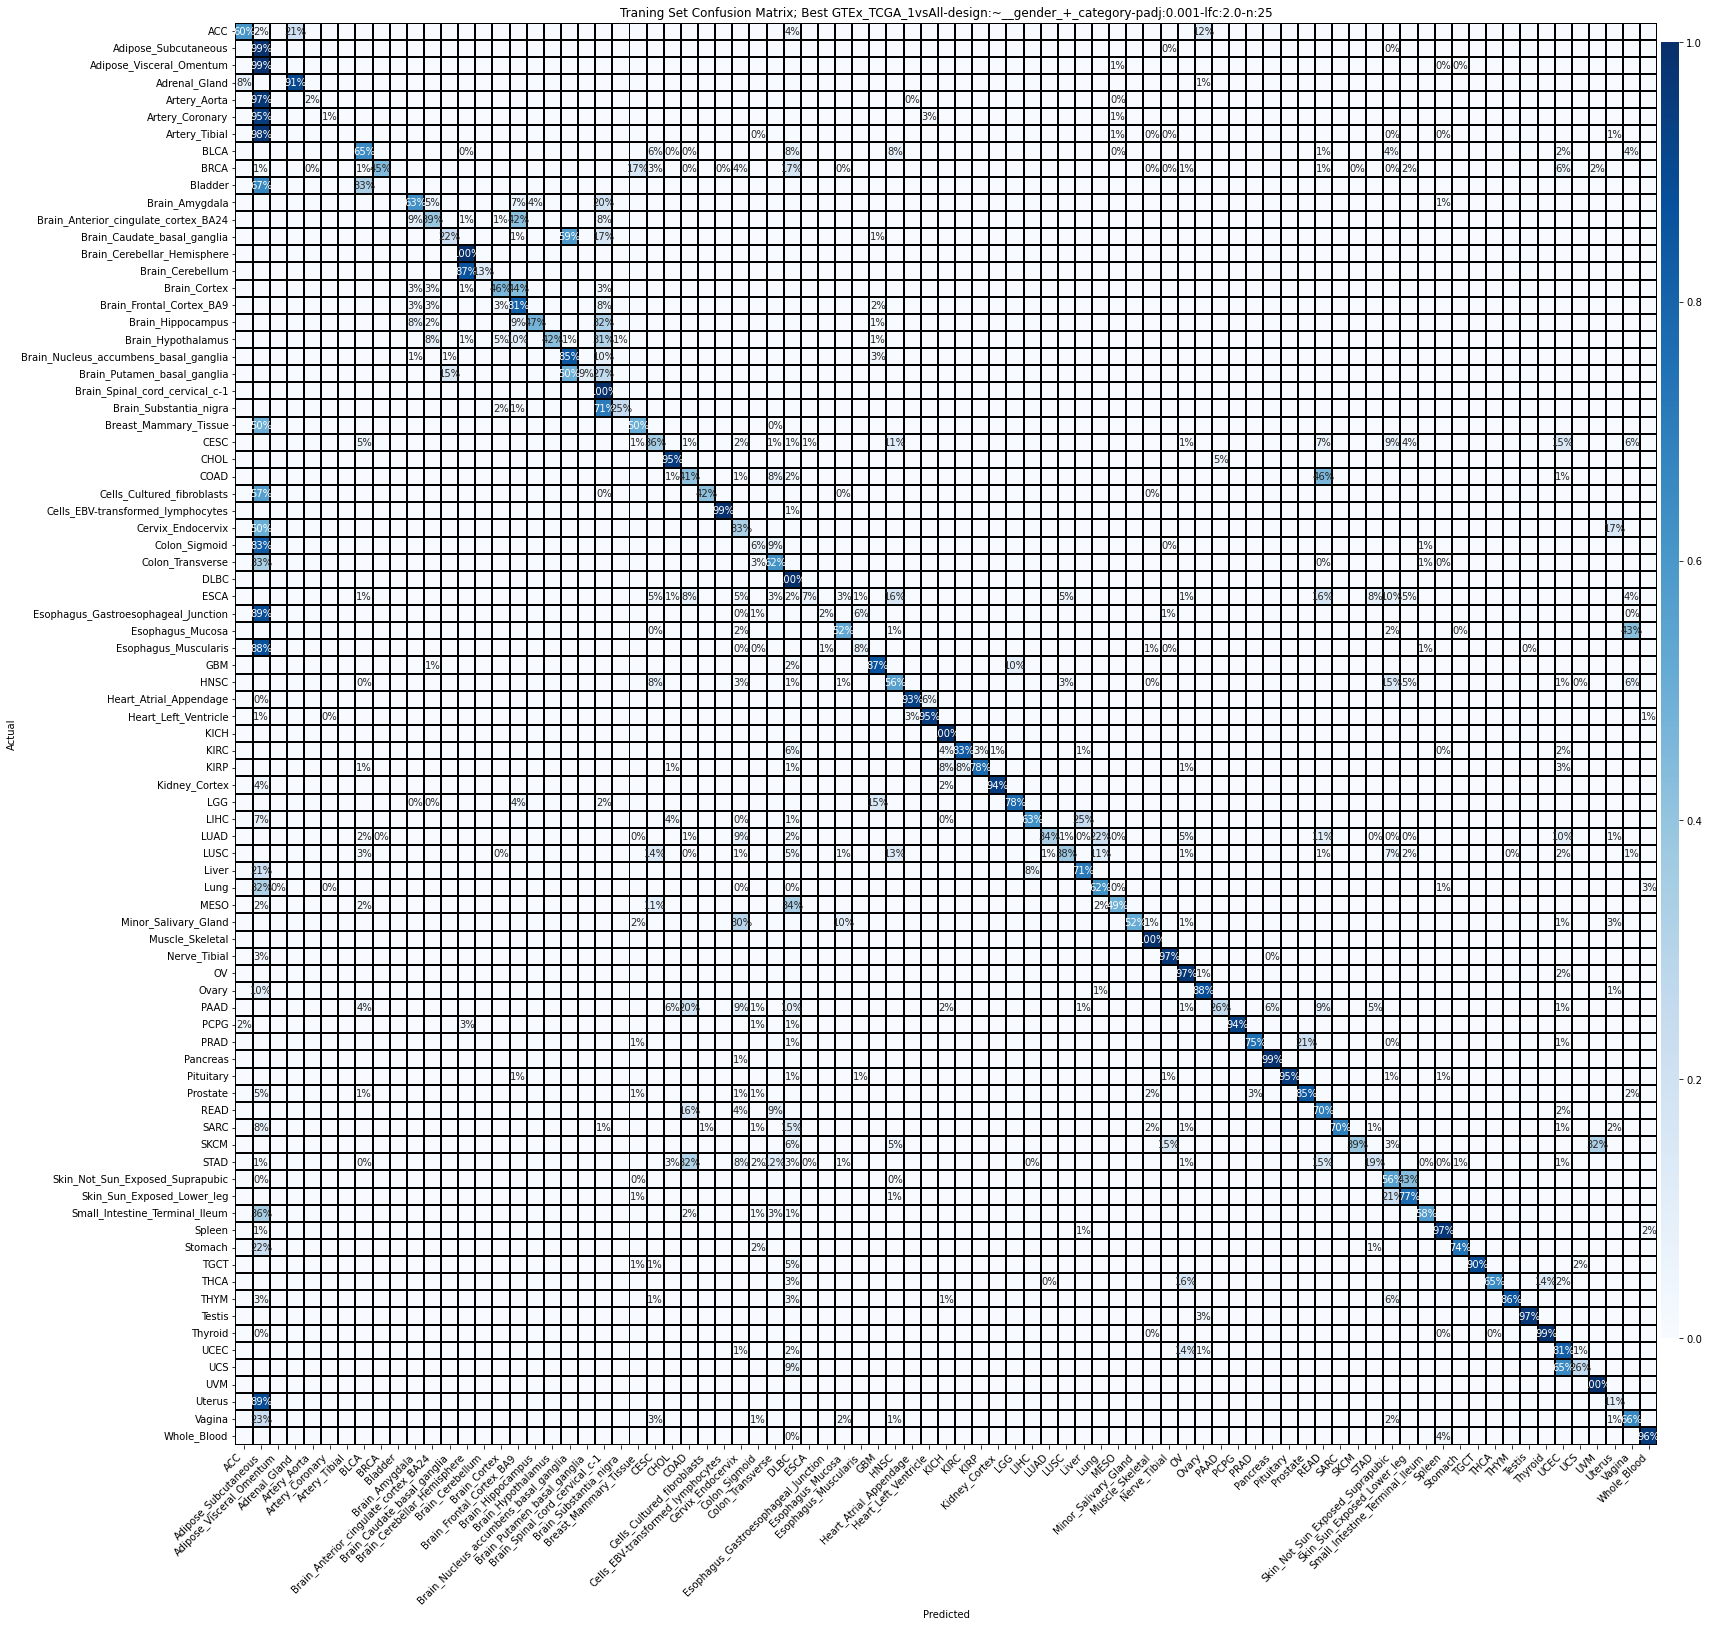

In [12]:
# plot the entire data set
title = "Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
pageWidthInInches  = 20 # 16 12 8
pageHeightInInches = 20 # 16,12 8

plotConfusionMatrix(confusionData, labels, annotations, imgOutDir, title, pageWidthInInches, pageHeightInInches)

save: img/fractionsAsMulticlassClassificationPOC/p1-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


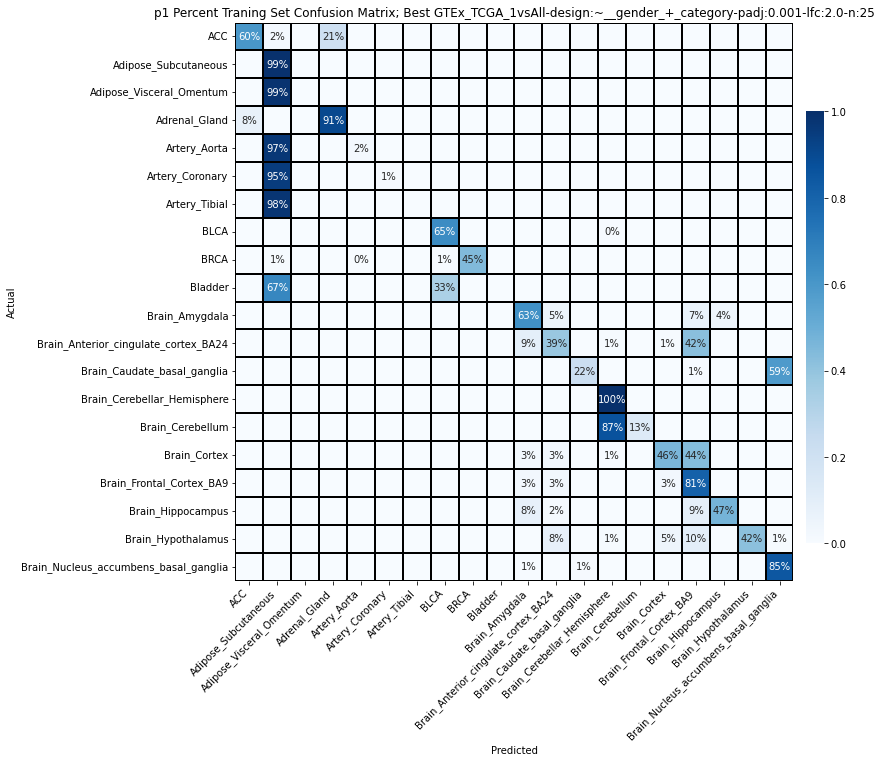

In [13]:
title = "p1 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=0, end=20, displayCounts=False)

save: img/fractionsAsMulticlassClassificationPOC/p1-Counts-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


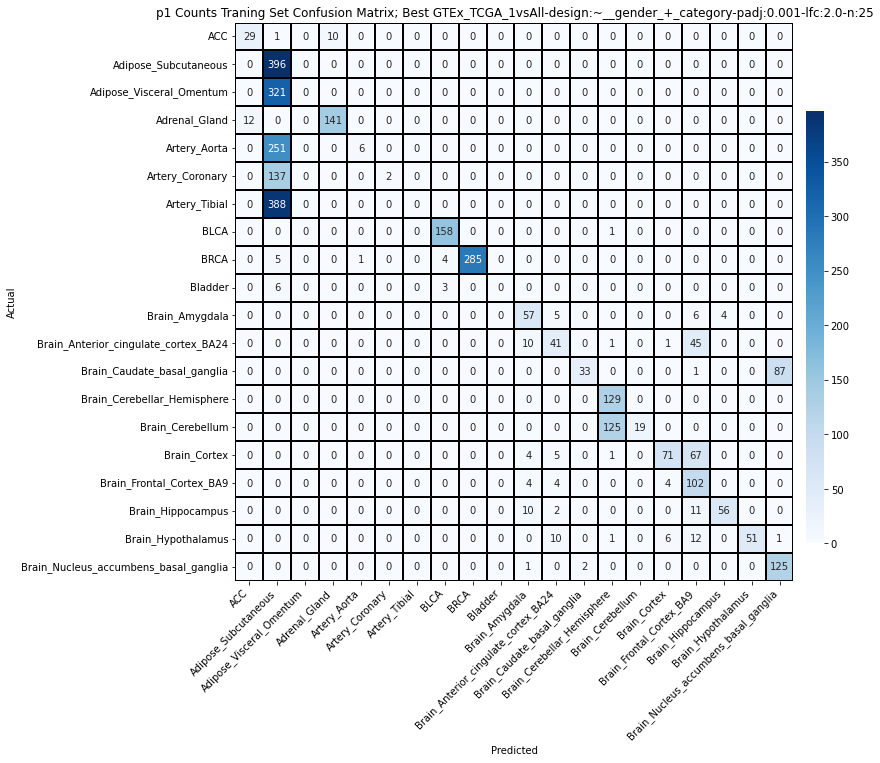

In [14]:
title = "p1 Counts Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=0, end=20, displayCounts=True)

save: img/fractionsAsMulticlassClassificationPOC/p2-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


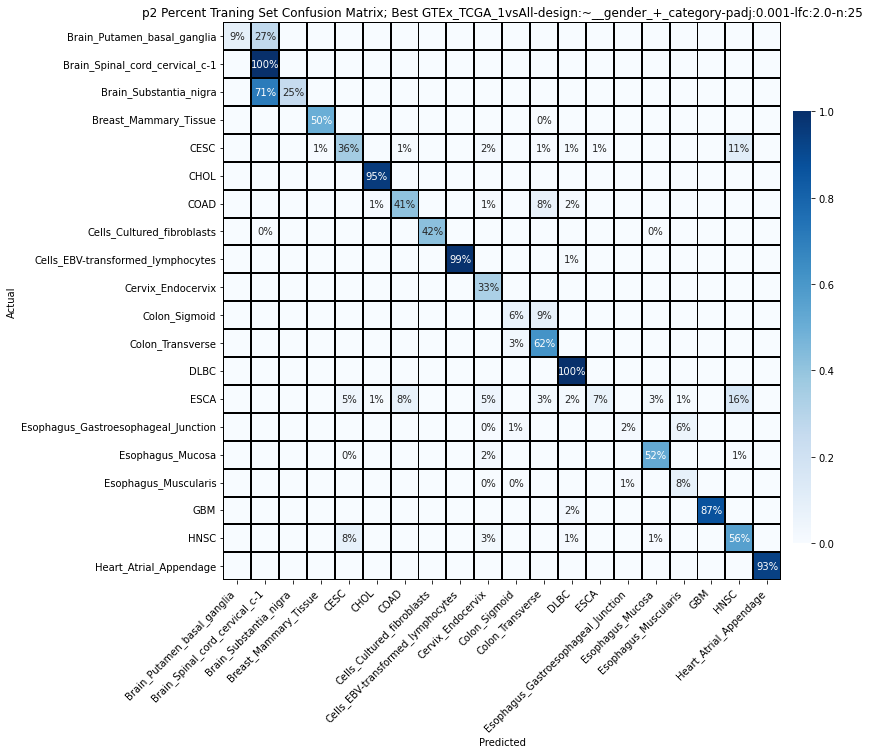

In [15]:
title = "p2 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=20, end=40, displayCounts=False)

save: img/fractionsAsMulticlassClassificationPOC/p3-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


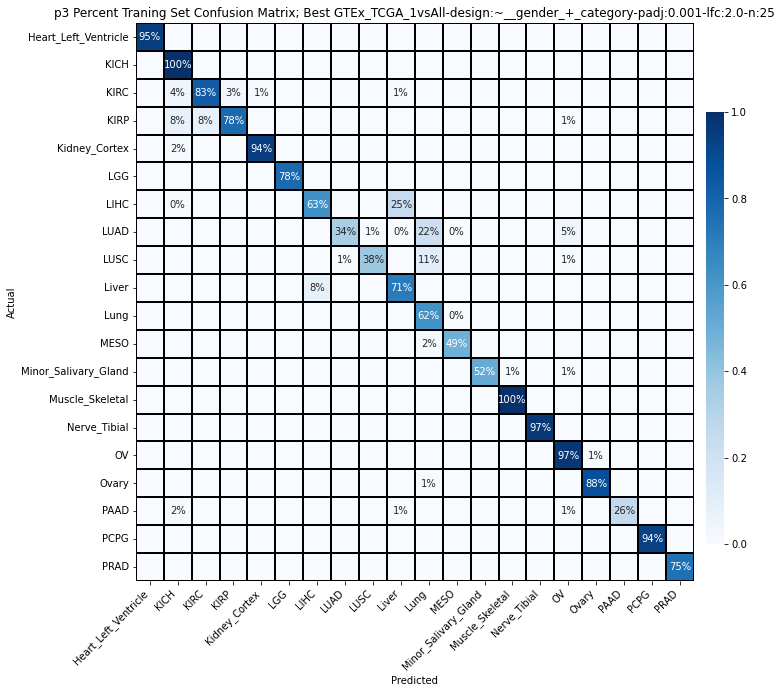

In [16]:
title = "p3 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=40, end=60)

save: img/fractionsAsMulticlassClassificationPOC/p3-Count-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


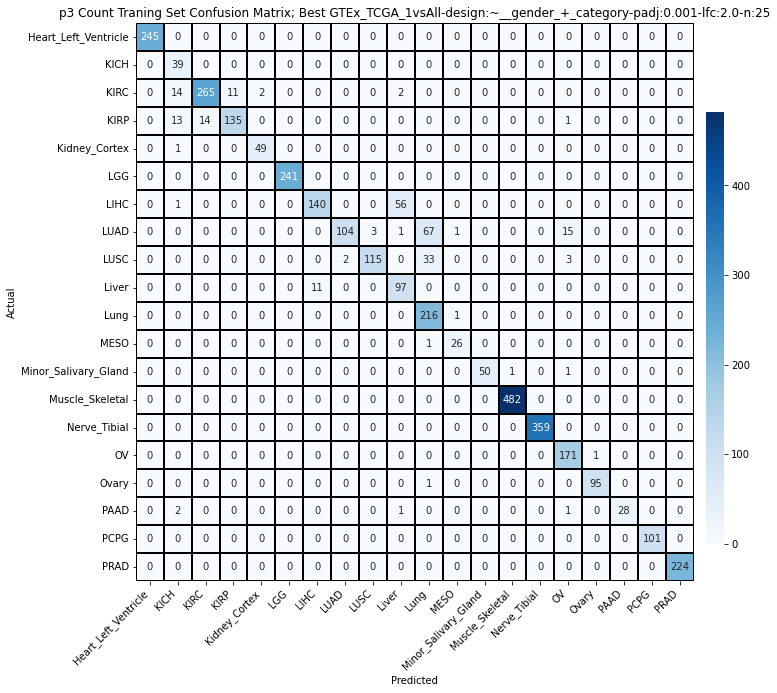

In [17]:
title = "p3 Count Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=40, end=60, displayCounts=True)

save: img/fractionsAsMulticlassClassificationPOC/p4-Percent-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


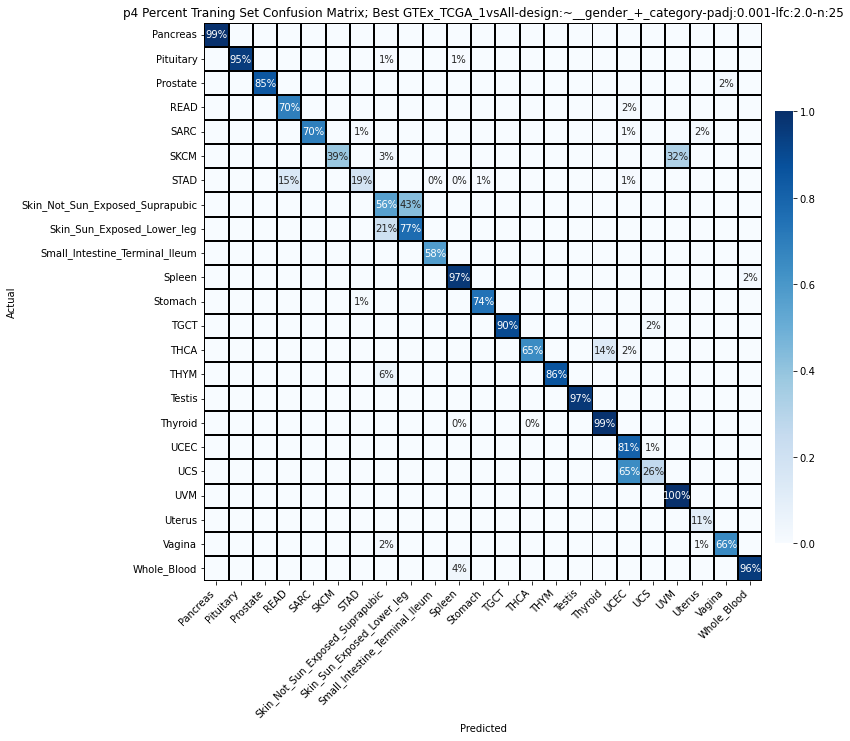

In [18]:
title = "p4 Percent Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=60, end=None)

save: img/fractionsAsMulticlassClassificationPOC/p4-Counts-Traning-Set-Confusion-Matrix-Best-GTEx_TCGA_1vsAlldesign__gender__categorypadj0001lfc20n25.png


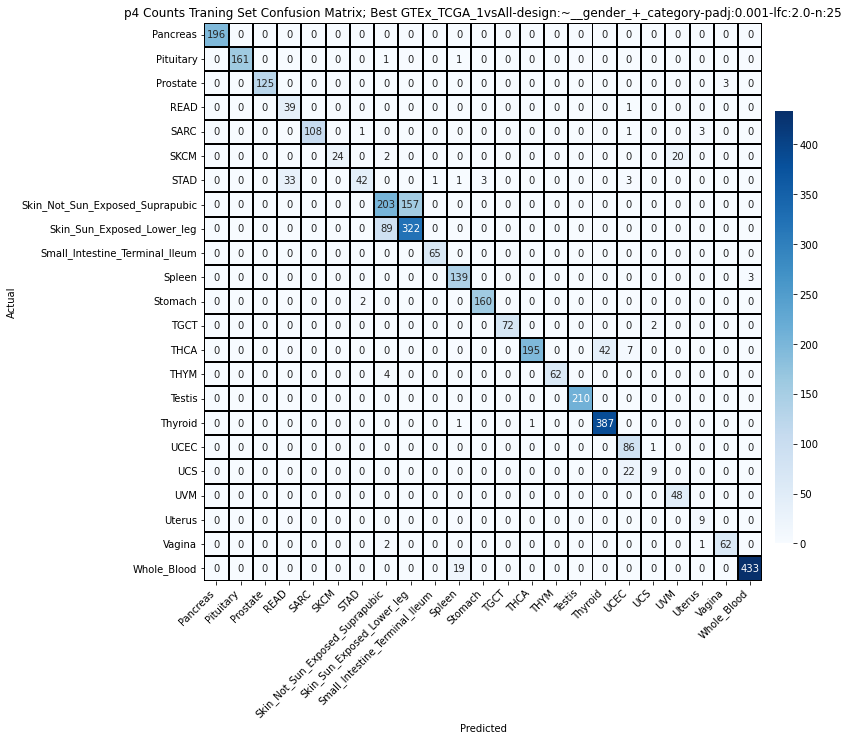

In [19]:
title = "p4 Counts Traning Set Confusion Matrix; Best GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25"
plotConfusionMatrixHelper(imgOutDir, title, cfMatrix, labels, start=60, end=None, displayCounts=True)